# Session 3 - Non-Parametric Regression

## Content

- [Polynomial Regression](#Polynomial-Regression)
- [Step Functions](#Step-Functions)
- [Regression Splines](#Regression-Splines)
- [Local Regression](#Local-Regression)
- [Generalized-Additive-Models](#Generalized-Additive-Models)

## Labs

- [Non-linear Modeling](#Lab-1:-Non-linear-Modeling)

In [1]:
# Import
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import norm
from statsmodels.nonparametric.kernel_regression import KernelReg
from pygam import LinearGAM, s, f, LogisticGAM
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from patsy import dmatrix

In [2]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

For this session, we are mostly going to work with the wage dataset.

In [3]:
df = pd.read_csv('data/Wage.csv')
df.head(3)

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


This dataset contains information on wages and individual characteristics.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3000 non-null   int64  
 1   year        3000 non-null   int64  
 2   age         3000 non-null   int64  
 3   sex         3000 non-null   object 
 4   maritl      3000 non-null   object 
 5   race        3000 non-null   object 
 6   education   3000 non-null   object 
 7   region      3000 non-null   object 
 8   jobclass    3000 non-null   object 
 9   health      3000 non-null   object 
 10  health_ins  3000 non-null   object 
 11  logwage     3000 non-null   float64
 12  wage        3000 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 304.8+ KB


Our main objective is going to be to explain wages using the observables contained in the dataset.

## Polynomial Regression and Step Functions

As we have seen in the first lecture, the most common way to introduce linearities is to replace the standard linear model 

$$
y_i = \beta_0 + \beta_1 x_i + \varepsilon_i
$$

with a polynomial function

$$
y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_2 x_i^3 + ... + \varepsilon_i
$$

Suppose we want to investigate the relationship between `wage` and `age`. Let's first plot the two variables.

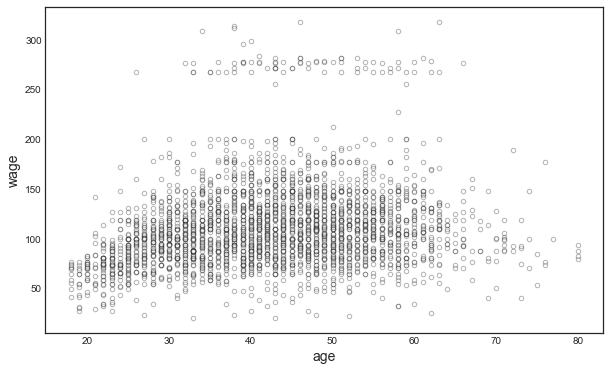

In [84]:
# Scatterplot of the data
df.plot.scatter('age','wage',color='w', edgecolors='k', alpha=0.3);

The relationship is highly complex and non-linear. Let's expand our linear regression polynomials of different degrees: 1 to 5.

In [130]:
X1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

Our dependent varaible is going to be a dummy for income above 250.000 USD.

In [131]:
# Get X and y
X = df.age
y = df.wage
y_binary = (df.wage > 250).map({False:0, True:1}).values

What do our variables look like?

In [132]:
print('X4:\n', X4[:5])
print('y:\n', y_binary[:5])

X4:
 [[1.000000e+00 1.800000e+01 3.240000e+02 5.832000e+03 1.049760e+05]
 [1.000000e+00 2.400000e+01 5.760000e+02 1.382400e+04 3.317760e+05]
 [1.000000e+00 4.500000e+01 2.025000e+03 9.112500e+04 4.100625e+06]
 [1.000000e+00 4.300000e+01 1.849000e+03 7.950700e+04 3.418801e+06]
 [1.000000e+00 5.000000e+01 2.500000e+03 1.250000e+05 6.250000e+06]]
y:
 [0 0 0 0 0]


If we run a linear regression on a 4-degree polinomial expansion of `age`, this is what it looks like`:

In [129]:
# Fit ols on 4th degree polynomial
fit = sm.OLS(y, X4).fit()
fit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


In this case, the single coefficients are not of particular interest. We are mostly interested in the best capturing the relationship between `age` and `wage`. How can we pick among thedifferent polynomials?

We compare different polynomial degrees. For each regression, we are going to look at a series of metrics:
 - absolute residuals
 - sum of squared residuals
 - the difference in SSR w.r (SSR).t the 0-degree case
 - F statistic

In [10]:
# Run regressions
fit_1 = sm.OLS(y, X1).fit()
fit_2 = sm.OLS(y, X2).fit()
fit_3 = sm.OLS(y, X3).fit()
fit_4 = sm.OLS(y, X4).fit()
fit_5 = sm.OLS(y, X5).fit()

# Compare fit
sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


The polynomial degree 4 seems best.

In [11]:
# Set X
X_poly = X4

Since we have a binary dependent variable, it would be best to account for it in our regression framework. One way to do so, is to run a logistic regression. 

How to interpret a Logistic Regression?

$$
y = \mathbb I \ \Big( \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_2 x_i^3 + ... + \varepsilon_i \Big)
$$

where $\mathbb I(\cdot)$ is an indicator function and now $\varepsilon_i$ is the error term.

Depending on the assumed distribution of the error term, we get different results. I list below the error types supported by the `Binomial` family. 

In [12]:
# List link functions for the Binomial family
sm.families.family.Binomial.links

[statsmodels.genmod.families.links.logit,
 statsmodels.genmod.families.links.probit,
 statsmodels.genmod.families.links.cauchy,
 statsmodels.genmod.families.links.log,
 statsmodels.genmod.families.links.cloglog,
 statsmodels.genmod.families.links.identity]

We are going to pick the `logit` link, i.e. we are going to assume that the error term is Type 1 Extreme Value (or Gumbel) distributed. It instead we take the usual standard normal distribution assumption for $\varepsilon_i$, we get `probit` regression.

In [13]:
# Pick the logit link for the Binomial family
logit_link = sm.families.Binomial(sm.genmod.families.links.logit())

Given the error distribution, we can write the probability that $y=1$ as

$$
\Pr(y=1) = \frac{e^{ \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_2 x_i^3 + ... + \varepsilon_i }}{1 + e^{ \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_2 x_i^3 + ... + \varepsilon_i } }
$$

We now estimate the regression and plot the estimated relationship between `age` and `wage`.

In [14]:
# Run logistic regression
logit_poly = sm.GLM(y, X_poly, family=logit_link).fit()
logit_poly.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-109.5530,47.655,-2.299,0.022,-202.956,-16.150
x1,8.9950,4.187,2.148,0.032,0.789,17.201
x2,-0.2816,0.135,-2.081,0.037,-0.547,-0.016
x3,0.0039,0.002,2.022,0.043,0.000,0.008
x4,-1.949e-05,9.91e-06,-1.966,0.049,-3.89e-05,-6.41e-08


What is the difference with the linear model?

In [15]:
# Run logistic regression
ols_poly = sm.OLS(y, X_poly).fit()
ols_poly.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-0.1126,0.240,-0.468,0.640,-0.584,0.359
x1,0.0086,0.024,0.363,0.717,-0.038,0.055
x2,-0.0002,0.001,-0.270,0.787,-0.002,0.001
x3,3.194e-06,1.23e-05,0.260,0.795,-2.09e-05,2.73e-05
x4,-1.939e-08,6.57e-08,-0.295,0.768,-1.48e-07,1.09e-07


The magnitude of the coefficients is different, but the signs are the same.

In [16]:
# Generate grid for prediction
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)
print("Age range:", df.age.min(), "to", df.age.max())

Age range: 18 to 80


In [17]:
# Generate predictions
X_poly_test = PolynomialFeatures(4).fit_transform(age_grid)
pred1 = logit_poly.predict(X_poly_test)

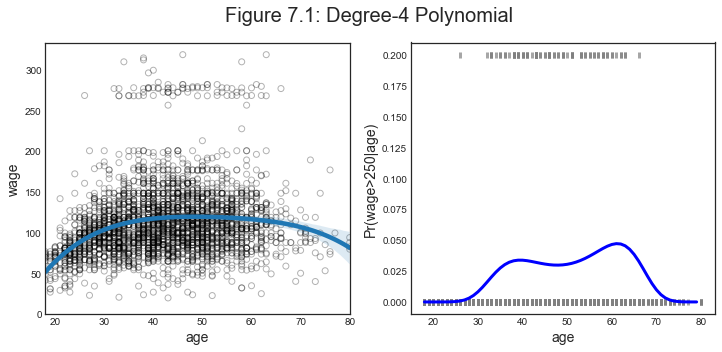

In [18]:
# Figure 7.1
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 7.1: Degree-4 Polynomial')

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
sns.regplot(x=df.age, y=df.wage, order=4, truncate=True, scatter=False, ax=ax1)
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, pred1, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

## Step Functions

Using polynomial functions of the features as predictors in a linear model imposes a global structure on the non-linear function of `age`. We can instead use step functions in order to avoid imposing such a global structure. Here we break the range of `age` into bins, and fit a different constant in each bin.

In practice this implies first picking $K$ cutpoints $c_1 , c_2 , . . . , c_K$ in the range of `age`,
and then construct $K + 1$ new variables

$$
C_0(`age`) = \mathbb I ( `age` < c_1) \\
C_1(`age`) = \mathbb I ( c_1 < `age` < c_2) \\
C_2(`age`) = \mathbb I ( c_2 < `age` < c_3) \\
... \\
C_{K-1}(`age`) = \mathbb I ( c_{K-1} < `age` < c_K) \\
C_K(`age`) = \mathbb I ( c_K < `age`) \\
$$

where $\mathbb I(\cdot)$ is the indicator function.

First, we generate the cuts.

In [19]:
# Generate cuts for the variable age
df_cut, bins = pd.cut(df.age, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)
type(df_cut)

pandas.core.series.Series

Let's generate a DataFrame out of this series.

In [20]:
# Generate bins for "age" from the cuts
df_steps = pd.concat([df.age, df_cut, df.wage], keys=['age','age_cuts','wage'], axis=1)
df_steps.head(5)

,age,age_cuts,wage
0,18,"(17.938, 33.5]",75.043154
1,24,"(17.938, 33.5]",70.476020
2,45,"(33.5, 49.0]",130.982177
3,43,"(33.5, 49.0]",154.685293
4,50,"(49.0, 64.5]",75.043154


Now we can generate different dummy variables out of each bin.

In [21]:
# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)
df_steps_dummies.head(5)

,const,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1.0,1,0,0,0
1,1.0,1,0,0,0
2,1.0,0,1,0,0
3,1.0,0,1,0,0
4,1.0,0,0,1,0


We are now ready to run our regression

In [22]:
# Generate our new X variable
X_step = df_steps_dummies.drop(df_steps_dummies.columns[1], axis=1)

In [30]:
# OLS Regression on step functions
ols_step = sm.OLS(df.wage, X_step).fit()
pred2 = ols_step.predict(X_step_test)
ols_step.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.264,97.053
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.466,27.641
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.610,27.719
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.139,17.420


From the regression outcome we can see that most bin coefficients are significant, except for the last one.

In [31]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)
bin_mapping

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [32]:
# Get dummies, drop first dummy category, add constant
X_step_test = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis=1))
X_step_test.head()

,const,2,3,4
0,1.0,0,0,0
1,1.0,0,0,0
2,1.0,0,0,0
3,1.0,0,0,0
4,1.0,0,0,0


We are going again to run a logistic regression, given that our outcome is binary.

In [37]:
# Logistic regression on step functions
logit_step = sm.GLM(y, X_step, family=logit_link).fit()
pred3 = logit_step.predict(X_step_test)
logit_step.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-5.0039,0.449,-11.152,0.000,-5.883,-4.124
"(33.5, 49.0]",1.5998,0.474,3.378,0.001,0.672,2.528
"(49.0, 64.5]",1.7147,0.488,3.512,0.000,0.758,2.672
"(64.5, 80.0]",0.7413,1.102,0.672,0.501,-1.420,2.902


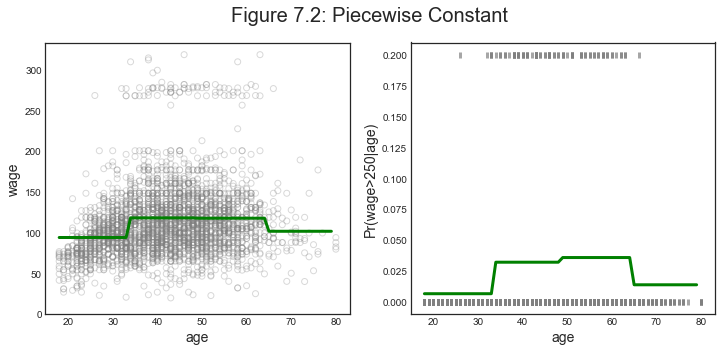

In [38]:
# Figure 7.2
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 7.2: Piecewise Constant')

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='grey', alpha=0.3)
ax1.plot(age_grid, pred2, c='g')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color='g')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

## Regression Splines

Spline regression, or piece-wise polynomial regression, involves fitting separate low-degree polynomials
over different regions of $X$. The idea is to have one regression specification but with different coefficients in different parts of the $X$ range. The points where the coefficients change are called knots.

For example, we could have a third degree polynomial *and* splitting the sample in two.

$$
y_{i}=\left\{\begin{array}{ll}
\beta_{01}+\beta_{11} x_{i}+\beta_{21} x_{i}^{2}+\beta_{31} x_{i}^{3}+\epsilon_{i} & \text { if } x_{i}<c \\
\beta_{02}+\beta_{12} x_{i}+\beta_{22} x_{i}^{2}+\beta_{32} x_{i}^{3}+\epsilon_{i} & \text { if } x_{i} \geq c
\end{array}\right.
$$

We have now two sets of coefficients, one for each subsample.

Generally, using more knots leads to a more flexible piecewise polynomial. Also increasing the degree of the polynomial increases the degree of flexibility.

We are now going to plot 4 different examples for the `age` `wage` relationship:

1. Discontinuous piecewise cubic
2. Continuous piecewise cubic
3. Quadratic (continuous)
4. Continuous piecewise linear

In [39]:
# Cut dataset
df_short = df.iloc[:80,:]
age_grid_short = np.arange(df_short.age.min(), df_short.age.max()+1).reshape(-1,1)

In [40]:
# 1. Discontinuous piecewise cubic
df_short_1 = df_short[df_short['age']<50]
x3_1 = PolynomialFeatures(3).fit_transform(df_short_1.age.values.reshape(-1,1))
fit1_1 = sm.GLS(df_short_1.wage, x3_1).fit()
age_grid_short_1 = np.arange(df_short_1.age.min(), df_short_1.age.max()+2).reshape(-1,1)
pred1_1 = fit1_1.predict(PolynomialFeatures(3).fit_transform(age_grid_short_1))

df_short_2 = df_short[df_short['age']>=50]
x3_2 = PolynomialFeatures(3).fit_transform(df_short_2.age.values.reshape(-1,1))
fit1_2 = sm.GLS(df_short_2.wage, x3_2).fit()
age_grid_short_2 = np.arange(df_short_2.age.min(), df_short_2.age.max()+1).reshape(-1,1)
pred1_2 = fit1_2.predict(PolynomialFeatures(3).fit_transform(age_grid_short_2))

In [41]:
# 2. Continuous piecewise cubic
spline2 = "bs(x, knots=(50,50,50), degree=3, include_intercept=False)"
transformed_x = dmatrix(spline2, {"x": df_short.age}, return_type='dataframe')
fit2 = sm.GLM(df_short.wage, transformed_x).fit()
pred2 = fit2.predict(dmatrix(spline2, {"x": age_grid_short}, return_type='dataframe'))

In [42]:
# 3. Quadratic (continuous)
spline3 = "bs(x, knots=(%s,%s), degree=2, include_intercept=False)" % (min(df_short.age), min(df_short.age))
transformed_x = dmatrix(spline3, {"x": df_short.age}, return_type='dataframe')
fit3 = sm.GLM(df_short.wage, transformed_x).fit()
pred3 = fit3.predict(dmatrix(spline3, {"x": age_grid_short}, return_type='dataframe'))

In [43]:
# 4. Continuous piecewise linear
spline4 = "bs(x, knots=(%s,50), degree=1, include_intercept=False)" % min(df_short.age)
transformed_x = dmatrix(spline4, {"x": df_short.age}, return_type='dataframe')
fit4 = sm.GLM(df_short.wage, transformed_x).fit()
pred4 = fit4.predict(dmatrix(spline4, {"x": age_grid_short}, return_type='dataframe'))

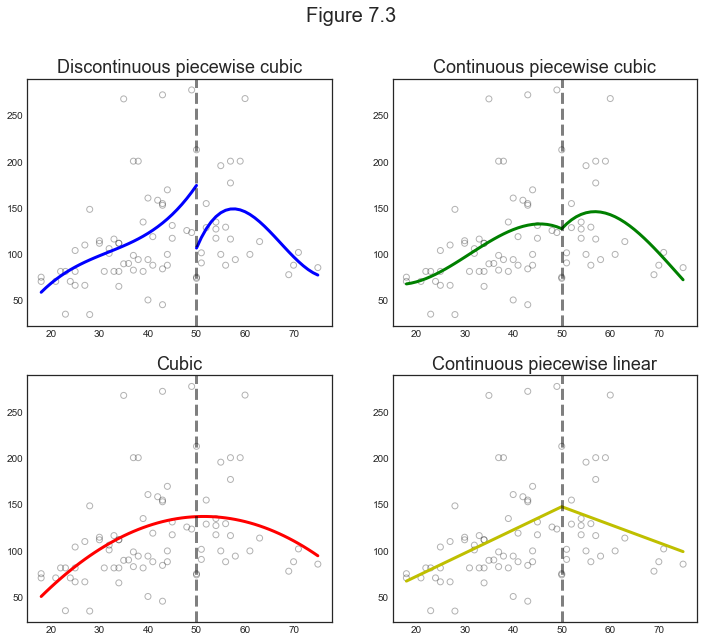

In [44]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,10))
fig.suptitle('Figure 7.3')

# Discontinuous piecewise cubic
ax1.plot(age_grid_short_1, pred1_1, color='b')
ax1.plot(age_grid_short_2, pred1_2, color='b')
ax1.set_title('Discontinuous piecewise cubic')
# Continuous piecewise cubi
ax2.plot(age_grid_short, pred2, color='g')
ax2.set_title('Continuous piecewise cubic')
# Cubic (continuous)
ax3.plot(age_grid_short, pred3, color='r')
ax3.set_title('Cubic')
# Continuous piecewise linear
ax4.plot(age_grid_short, pred4, color='y')
ax4.set_title('Continuous piecewise linear')

for ax in (ax1,ax2,ax3,ax4):
    ax.scatter(df_short.age, df_short.wage, facecolor='None', edgecolor='k', alpha=0.3)
    ax.axvline(x=50, color='k', linestyle='--', alpha=0.5)

The first example makes us think on why would we want out function to be discontinuous. Unless we expect a sudden wage jump at a certain age, we would like the function to be continuous. However, if for example we split `age` around the retirement age, we might expect a discontinuity. 

The second example (top right) makes us think on why would we want out function not to be differentiable. Unless we have some specific mechanism in mind, ususally there is a trade-off between making the function non-differentiable or increasing the degree of the polynomial, as the last two examples show us. We get a similar fit with a quadratic fit or a discontinuous linear fit. The main difference is that in the second case we are picking the discontinuity point by hand instead of letting the data choose how to change the slope of the curve.

### The Spline Basis Representation

How can we fit a piecewise degree-d polynomial under the constraint that it (and possibly its first d − 1 derivatives) be continuous?

The most direct way to represent a cubic spline is to start off with a basis for a cubic polynomial—namely, x,x2,x3—and then add one truncated power basis function per knot. A truncated power basis function is defined as

$$ 
h(x, c)=(x-c)_{+}^{3} = \Bigg\{\begin{array}{cl}
(x-c)^{3} & \text { if } x>c \\
0 & \text { otherwise }
\end{array}
$$

One can show that adding a term of the form $\beta_4 h(x, c)$ to the model for a cubic polynomial will lead to a discontinuity in only the third derivative at $c$; the function will remain continuous, with continuous first and second derivatives, at each of the knots.

#### Cubic splines

One way to specify the spline is using nodes and degrees of freedom.

In [46]:
# Specifying 3 knots and 3 degrees of freedom
spline5 = "bs(x, knots=(25,40,60), degree=3, include_intercept=False)"
transformed_x5 = dmatrix(spline5, {"x": df.age}, return_type='dataframe')
ols_spline1 = sm.OLS(df.wage, transformed_x5).fit()
pred5 = ols_spline1.predict(dmatrix(spline5, {"x": age_grid}, return_type='dataframe'))

# Check parameters
ols_spline1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,60.4937,9.460,6.394,0.000,41.944,79.043
"bs(x, knots=(25, 40, 60), degree=3, include_intercept=False)[0]",3.9805,12.538,0.317,0.751,-20.603,28.564
"bs(x, knots=(25, 40, 60), degree=3, include_intercept=False)[1]",44.6310,9.626,4.636,0.000,25.756,63.506
"bs(x, knots=(25, 40, 60), degree=3, include_intercept=False)[2]",62.8388,10.755,5.843,0.000,41.750,83.927
"bs(x, knots=(25, 40, 60), degree=3, include_intercept=False)[3]",55.9908,10.706,5.230,0.000,34.998,76.983
"bs(x, knots=(25, 40, 60), degree=3, include_intercept=False)[4]",50.6881,14.402,3.520,0.000,22.450,78.927
"bs(x, knots=(25, 40, 60), degree=3, include_intercept=False)[5]",16.6061,19.126,0.868,0.385,-20.896,54.108


#### No knots

When we fit a spline, where should we place the knots? 

The regression spline is most flexible in regions that contain a lot of knots, because in those regions the polynomial coefficients can change rapidly. Hence, one option is to place more knots in places where we feel the function might vary most rapidly, and to place fewer knots where it seems more stable. While this option can work well, in practice it is common to place knots in a uniform fashion. One way to do this is to specify the desired degrees of freedom, and then have the software automatically place the corresponding number of knots at uniform quantiles of the data.

In [47]:
# Specifying degree 3 and 6 degrees of freedom 
spline6 = "bs(x, df=6, degree=3, include_intercept=False)"
transformed_x6 = dmatrix(spline6, {"x": df.age}, return_type='dataframe')
ols_spline2 = sm.OLS(df.wage, transformed_x6).fit()
pred6 = ols_spline2.predict(dmatrix(spline6, {"x": age_grid}, return_type='dataframe'))

# Check parameters
ols_spline2.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,56.3138,7.258,7.759,0.000,42.088,70.539
"bs(x, df=6, degree=3, include_intercept=False)[0]",27.8240,12.435,2.238,0.025,3.453,52.195
"bs(x, df=6, degree=3, include_intercept=False)[1]",54.0625,7.127,7.585,0.000,40.093,68.032
"bs(x, df=6, degree=3, include_intercept=False)[2]",65.8284,8.323,7.909,0.000,49.515,82.142
"bs(x, df=6, degree=3, include_intercept=False)[3]",55.8127,8.724,6.398,0.000,38.714,72.911
"bs(x, df=6, degree=3, include_intercept=False)[4]",72.1315,13.745,5.248,0.000,45.192,99.071
"bs(x, df=6, degree=3, include_intercept=False)[5]",14.7509,16.209,0.910,0.363,-17.018,46.519


#### Natural splines

A natural spline is a regression spline with additional boundary constraints: the function is required to be linear at the boundary (in the region where X is smaller than the smallest knot, or larger than the largest knot). This addi- tional constraint means that natural splines generally produce more stable estimates at the boundaries.

In [57]:
# Natural spline with 4 degrees of freedom
spline7 = "cr(x, df=4)"
transformed_x7 = dmatrix(spline7, {"x": df.age}, return_type='dataframe')
ols_spline3 = sm.OLS(df.wage, transformed_x7).fit()
pred7 = ols_spline3.predict(dmatrix(spline7, {"x": age_grid}, return_type='dataframe'))

# Check parameters
ols_spline3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,79.6421,1.773,44.918,0.000,76.166,83.119
"cr(x, df=4)[0]",-14.6678,3.436,-4.269,0.000,-21.405,-7.931
"cr(x, df=4)[1]",36.8111,1.950,18.881,0.000,32.988,40.634
"cr(x, df=4)[2]",35.9349,2.056,17.476,0.000,31.903,39.967
"cr(x, df=4)[3]",21.5639,6.989,3.085,0.002,7.860,35.268


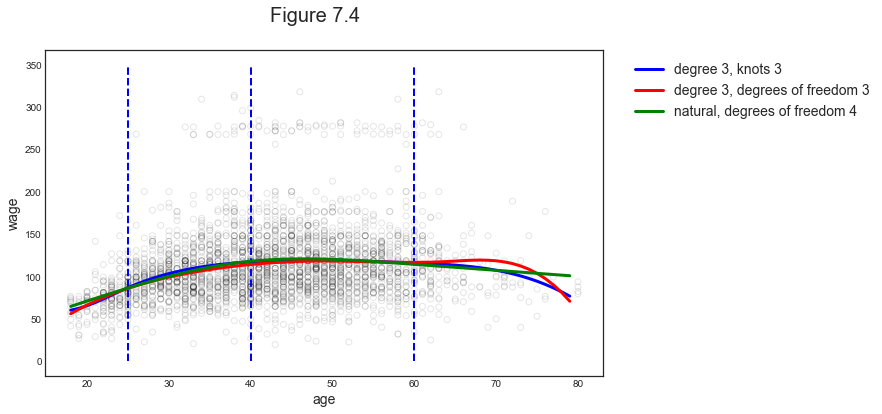

In [66]:
fig, ax = plt.subplots(1,1)
fig.suptitle('Figure 7.4')

# Scatter
ax.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
ax.plot(age_grid, pred5, color='b', label='degree 3, knots 3')
ax.plot(age_grid, pred6, color='r', label='degree 3, degrees of freedom 3')
ax.plot(age_grid, pred7, color='g', label='natural, degrees of freedom 4')
[ax.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
ax.legend(bbox_to_anchor=(1.5, 1.0))
ax.set_xlabel('age'), ax.set_ylabel('wage');

### Comparison to Polynomial Regression

Regression splines often give superior results to polynomial regression. This is because unlike polynomials, which must use a high degree to produce flexible fits, splines introduce flexibility by increasing the number of knots but keeping the degree fixed. 

We are now fitting a polynomial of degree 15 and a spline with 15 degrees of freedom.

In [63]:
# Polynomial of degree 15
X15 = PolynomialFeatures(15).fit_transform(df.age.values.reshape(-1,1))
ols_poly_15 = sm.OLS(df.wage, X15).fit()
pred8 = ols_poly_15.predict(PolynomialFeatures(15).fit_transform(age_grid))

# Spline with 15 degrees of freedon
spline15 = "bs(x, df=15, degree=3, include_intercept=False)"
X_spline15 = dmatrix(spline15, {"x": df.age}, return_type='dataframe')
ols_spline_15 = sm.OLS(df.wage, X_spline15).fit()
pred9 = ols_spline_15.predict(dmatrix(spline15, {"x": age_grid}, return_type='dataframe'))

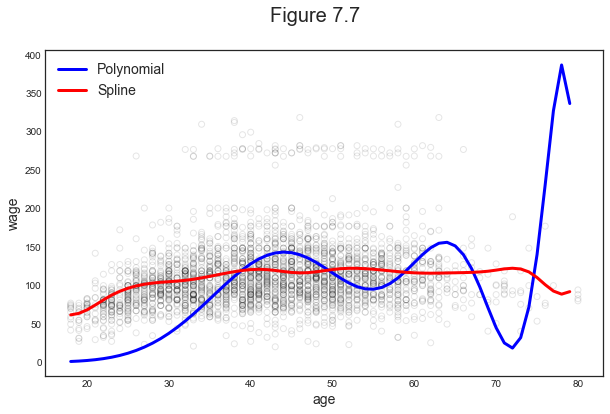

In [85]:
# Figure 7.7
fig, ax = plt.subplots(1,1)
fig.suptitle('Figure 7.7')

# Plot
ax.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
ax.plot(age_grid, pred8, color='b', label='Polynomial')
ax.plot(age_grid, pred9, color='r', label='Spline')
ax.set_xlabel('age'); ax.set_ylabel('wage'); ax.legend();

As we can see, despite the two regressions having the same degrees of freedom, the polynomial fit is much more volatile. We can compare them along some dimensions.

In [69]:
# Compare fits, with ols as baseline
ols = sm.OLS(df.wage, df.age).fit()
sm.stats.anova_lm(ols, ols_poly_15, ols_spline_15, typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2999.0,6.402646e+06,0.0,NaN,NaN,NaN
1,2994.0,9.023503e+06,5.0,-2.620856e+06,-329.264805,1.0
2,2984.0,4.750362e+06,10.0,4.273141e+06,268.422721,0.0


The polynomial is so wiggly that it actually performs worse than linear regression.

## Local Regression

So far we have looked at so-called "*global methods*": methods that try to fit a unique function specification over the whole data. The function specification can be complex, as in the case of splines, but can be expressed globally.

Local regression is a different approach for fitting flexible non-linear functions, which involves computing the fit at a target point $x_0$ using only the nearby training observations.

#### Details

How does local regression work?

Ingredients: $X$, $y$.

How to you output a prediction $\hat y_i$ at a new point $x_i$?

1. Take a number of points in $X$ close to $x_i$: $X_{\text{close-to-i}}$
2. Assign a weight to each of there points
3. Fit a weigthed least squares regression of $X_{\text{close-to-i}}$ on $y_{\text{close-to-i}}$
4. Use the estimated coefficients $\hat \beta$ to predict $\hat y_i = \hat \beta_0 + \hat \beta_1 x_i$

In [70]:
# Set seed
np.random.seed(1)

# Generate data
X_sim = np.sort(np.random.uniform(0,1,100))
e = np.random.uniform(-.5,.5,100)
y_sim = -4*X_sim**2 + 3*X_sim + e

# True Generating process without noise
X_grid = np.linspace(0,1,100)
y_grid = -4*X_grid**2 + 3*X_grid

Let's visualize the simulated data and the curve without noise.

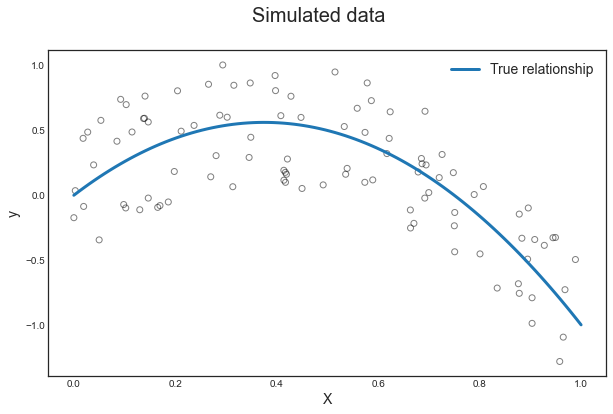

In [95]:
# Plot
fig, ax = plt.subplots(1,1)
fig.suptitle('Simulated data');

# Plot
ax.scatter(X_sim, y_sim, facecolor='None', edgecolor='k', alpha=0.5);
ax.plot(X_grid, y_grid, label='True relationship');
ax.set_xlabel('X'); ax.set_ylabel('y'); 
ax.legend();

Now we fit a local linear regression.

In [99]:
# Settings
spec = 'll'
bandwidth = 0.1
kernel = 'gaussian'

# Locally linear regression
local_reg = KernelReg(y_sim, X_sim.reshape(-1,1), 
                      var_type='c', 
                      reg_type=spec, 
                      bw=[bandwidth], 
                      ckertype=kernel)
y_hat = KernelReg.fit(local_reg)

What do the parameters mean?
 - `var_type`: dependent variable type (`c` i.e. *continuous*)
 - `reg_type`: local regression specification (`ll` i.e. *locally linear*)
 - `bw`      : bandwidth length (*0.1*)
 - `ckertype`: kernel type (*gaussian*)
 
What does the prediction looks like?

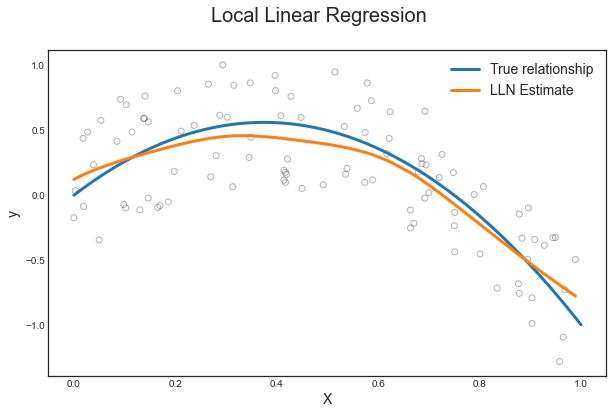

In [100]:
# Figure 7.9
fig, ax = plt.subplots()
fig.suptitle('Local Linear Regression');

# Plot scatter and lines
ax.scatter(X_sim, y_sim, facecolor='None', edgecolor='k', alpha=0.3);
ax.plot(X_grid, y_grid, label='True relationship');
ax.plot(X_sim, y_hat[0], label='LLN Estimate');
ax.set_xlabel('X'); ax.set_ylabel('y');
ax.legend();

How exactly was the prediction generated? It was generated pointwise. We are now going to look at the prediction at one particular point: $x_i=0.5$.

We proceed as follows:

1. We select the focal point: $x_i=0.5$
2. We select observations close to $\ x_i$, i.e. $x_{\text{close to i}} = \{ x \in X : |x_i - x| < 0.1 \} \ $ and $ \ y_{\text{close to i}} = \{ y \in Y : |x_i - x| < 0.1 \}$
3. We are going to run a linear regression of $y_{\text{close to i}}$ on $x_{\text{close to i}}$

In [96]:
# Get local X and y
x_i = 0.5
close_to_i = (x_i-bandwidth < X_sim) & (X_sim < x_i+bandwidth)
X_tilde = X_sim[close_to_i]
y_tilde = y_sim[close_to_i]

# Get local estimates
local_estimate = KernelReg.fit(local_reg, data_predict=[x_i])
y_i_hat = local_estimate[0]
beta_i_hat = local_estimate[1]
alpha_i_hat = y_i_hat - beta_i_hat*x_i
print('Estimates: alpha=%1.4f, beta=%1.4f' % (alpha_i_hat, beta_i_hat))

Estimates: alpha=0.7006, beta=-0.6141


Now we can use the locally estimated coefficients to predict the value of $\hat y_i(x_i)$ for $x_i = 0.5$. 

In [102]:
# Build local predictions
close_to_i_grid = (x_i-bandwidth < X_grid) & (X_grid < x_i+bandwidth)
X_grid_tilde = X_grid[close_to_i_grid].reshape(-1,1)
y_grid_tilde = alpha_i_hat + X_grid_tilde*beta_i_hat

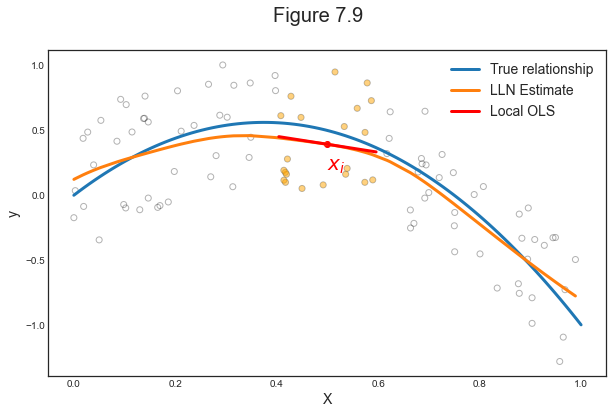

In [103]:
# Figure 7.9
fig, ax = plt.subplots()
fig.suptitle('Figure 7.9');

# Plot scatter and lines
ax.scatter(X_sim, y_sim, facecolor='None', edgecolor='k', alpha=0.3);
ax.plot(X_grid, y_grid, label='True relationship');
ax.plot(X_sim, y_hat[0], label='LLN Estimate');

# Add local details
ax.scatter(X_tilde, y_tilde, facecolor='orange', edgecolor='None', alpha=0.5);
ax.scatter(x_i, y_i_hat, facecolor='r', alpha=1);
ax.plot(X_grid_tilde, y_grid_tilde, color='r', label='Local OLS');

# Legend
ax.legend();
ax.annotate("$x_i$", (x_i, y_i_hat-0.2), color='r', fontsize=20);
ax.set_xlabel('X'); ax.set_ylabel('y'); 

We can zoom in and look only at the "*close to i*" sample.

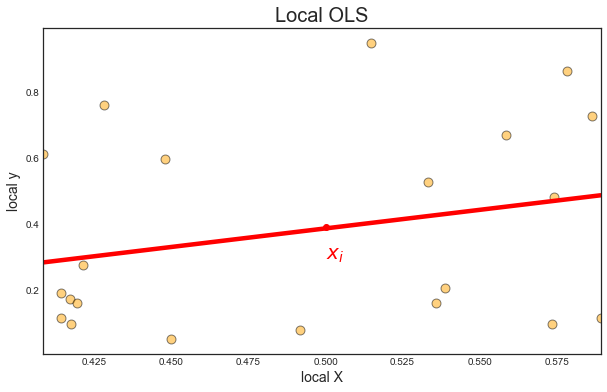

In [110]:
fig, ax = plt.subplots()
ax.set_title('Local OLS', fontsize=20);

# Zoom in
sns.regplot(x=X_tilde, y=y_tilde, ax=ax, order=1, 
            ci=None, scatter=False, line_kws={'color':'red'})
ax.scatter(X_tilde,y_tilde, facecolor='orange', edgecolor='k', alpha=0.5, s=80);
ax.scatter(x_i, y_i_hat, facecolor='r', alpha=1);
ax.annotate("$x_i$", (x_i, y_i_hat-0.1), color='r', fontsize=20);
ax.set_xlabel('local X'); ax.set_ylabel('local y'); 

Why is the line upward sloped? We forgot the gaussian weights.

In [106]:
# Weights
w = norm.pdf((X_sim-x_i)/bandwidth)

# Estimate LWS
mod_wls = sm.WLS(y_sim, sm.add_constant(X_sim), weights=w)
results = mod_wls.fit()

print('Estimates: alpha=%1.4f, beta=%1.4f' % tuple(results.params))

Estimates: alpha=0.7006, beta=-0.6141


We indeed got the same estimates as before. Note two things:
1. the badwidth defines the scale parameter of the gaussian weights
2. our locally linear regression is acqually global

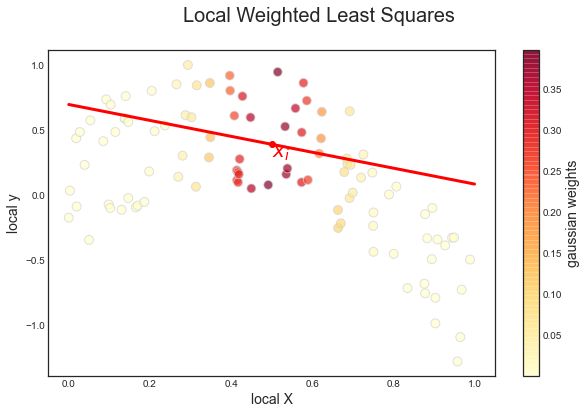

In [118]:
fig, ax = plt.subplots()
fig.suptitle('Local Weighted Least Squares');

# Zoom in
points = ax.scatter(X_sim, y_sim, c=w, cmap="YlOrRd", edgecolors='lightgrey', alpha=.7, s=80);
plt.colorbar(points, label='gaussian weights')
ax.plot(X_grid, results.params[0] + results.params[1]*X_grid, color='r')
ax.scatter(x_i, y_i_hat, facecolor='r', alpha=1);
ax.annotate("$x_i$", (x_i, y_i_hat-0.1), color='r', fontsize=20);
ax.set_xlabel('local X'); ax.set_ylabel('local y'); 

Now the slope is indeed negative, as in the locally linear regression.

## Generalized Additive Models

Imagine to extend the general regression framework to some separabily additive model of the form

$$
y_i = \beta_0 + \sum_{k=1}^K \beta_k f(x_{ik}) + \varepsilon_i
$$

In [125]:
# Set X and y
df['education_'] = LabelEncoder().fit_transform(df["education"])
X = df[['year','age','education_']].to_numpy()
y = df[['wage']].to_numpy()

## model
gam = LinearGAM(s(0, n_splines=8) + s(1, n_splines=10) + f(2))
gam.gridsearch(X, y);

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


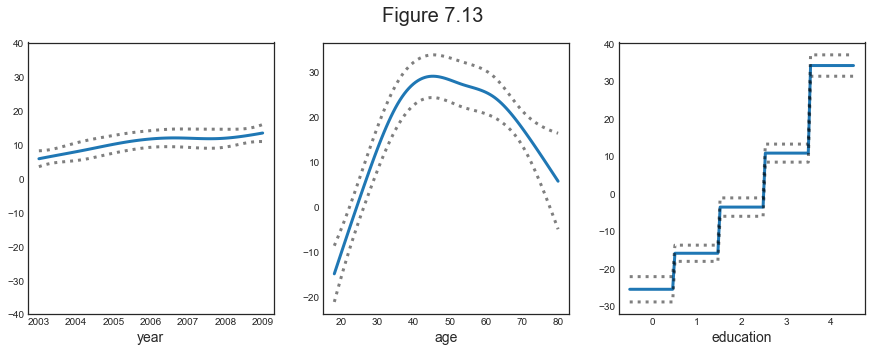

In [126]:
# Figure 7.13
fig, axs = plt.subplots(1,3,figsize=(15,5));
fig.suptitle('Figure 7.13')

# Plot
titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='k', ls=':', alpha=0.5)
    if i == 0:
        ax.set_ylim(-40,40)
    ax.set_xlabel(titles[i]);

In [127]:
# Binary dependent variable
y_binary = (y>250)

## Logit link function
logit_gam = LogisticGAM(s(0, n_splines=8) + s(1, n_splines=10) + f(2), fit_intercept=True)
logit_gam.gridsearch(X, y_binary);

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


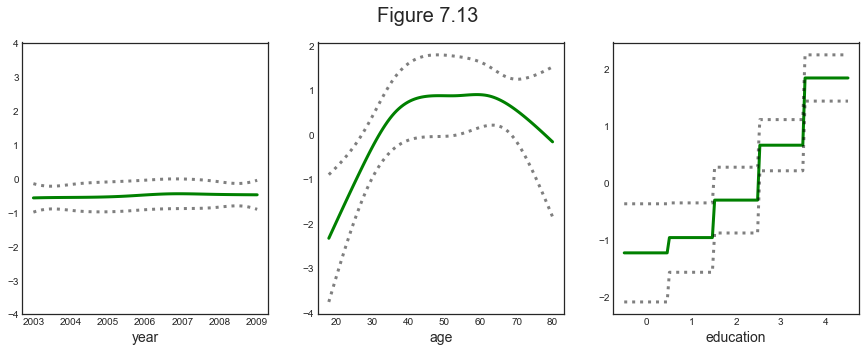

In [128]:
# Figure 7.13
fig, axs = plt.subplots(1,3,figsize=(15,5));
fig.suptitle('Figure 7.13')

# Plot
titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = logit_gam.generate_X_grid(term=i)
    pdep, confi = logit_gam.partial_dependence(term=i, width=.95)
    ax.plot(XX[:, i], pdep, c='g')
    ax.plot(XX[:, i], confi, c='k', ls=':', alpha=0.5)
    if i == 0:
        ax.set_ylim(-4,4)
    ax.set_xlabel(titles[i]);

# Labs

## Lab 1: Non-linear Modeling

In this lab, we'll explore how to generate the `Wage` dataset models we saw in class.

In [ ]:
df = pd.read_csv('data/Wage.csv')
df.head(3)

### Lab 1.1: Polynomial Regression and Step Functions

We first fit the polynomial regression model using the following commands:

In [ ]:
X1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

This syntax fits a linear model, using the `PolynomialFeatures()` function, in order to predict
wage using up to a fourth-degree polynomial in `age`. The `PolynomialFeatures()` command
allows us to avoid having to write out a long formula with powers
of `age`. We can then fit our linear model:

In [ ]:
fit2 = sm.GLS(df.wage, X4).fit()
fit2.summary().tables[1]

Next we consider the task of predicting whether an individual earns more
than \$250,000 per year. We proceed much as before, except that first we
create the appropriate response vector, and then we fit a logistic model using the `GLM()` function from `statsmodels`:

In [ ]:
# Create response matrix
y = (df.wage > 250).map({False:0, True:1}).values

# Fit logistic model
clf = sm.GLM(y, X4, family=sm.families.Binomial(sm.families.links.logit))
res = clf.fit()

We now create a grid of values for `age` at which we want predictions, and
then call the generic `predict()` function for each model:

In [ ]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Generate test data
X_test = PolynomialFeatures(4).fit_transform(age_grid)

# Predict the value of the generated ages
pred1 = fit2.predict(X_test) # salary
pred2 = res.predict(X_test)  # Pr(wage>250)

Finally, we plot the data and add the fit from the degree-4 polynomial.

In [ ]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, pred1, color = 'b')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, pred2, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

#### Deciding on a degree

In performing a polynomial regression we must decide on the degree of
the polynomial to use. One way to do this is by using hypothesis tests. We
now fit models ranging from linear to a degree-5 polynomial and seek to
determine the simplest model which is sufficient to explain the relationship
between `wage` and `age`.

We can do this using the `anova_lm()` function, which performs an
analysis of variance (ANOVA, using an F-test) in order to test the null
hypothesis that a model $M_1$ is sufficient to explain the data against the 
alternative hypothesis that a more complex model $M_2$ is required. In order
to use the `anova_lm()` function, $M_1$ and $M_2$ must be **nested models**: the
predictors in $M_1$ must be a subset of the predictors in $M_2$. In this case,
we fit five different models and sequentially compare the simpler model to
the more complex model (*Note:* you may get an *invalid value* Runtime Warning on the first model, because there is no "simpler model" to compare to):

In [ ]:
fit_1 = fit = sm.GLS(df.wage, X1).fit()
fit_2 = fit = sm.GLS(df.wage, X2).fit()
fit_3 = fit = sm.GLS(df.wage, X3).fit()
fit_4 = fit = sm.GLS(df.wage, X4).fit()
fit_5 = fit = sm.GLS(df.wage, X5).fit()

print(sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1))

The $p$-value comparing the linear Model 1 to the quadratic Model 2 is
essentially zero $(<10^{-32})$, indicating that a linear fit is not sufficient. Similarly
the $p$-value comparing the quadratic Model 2 to the cubic Model 3
is very low (0.0017), so the quadratic fit is also insufficient. The $p$-value
comparing the cubic and degree-4 polynomials, Model 3 and Model 4, is approximately
0.05 while the degree-5 polynomial Model 5 seems unnecessary
because its $p$-value is 0.37. Hence, either a cubic or a quartic polynomial
appear to provide a reasonable fit to the data, but lower- or higher-order
models are not justified.

As an alternative to using hypothesis tests and ANOVA, we could choose
the polynomial degree using cross-validation as we have in previous labs.

#### Step functions

In order to fit a step function, we use the `cut()` function:

In [ ]:
df_cut, bins = pd.cut(df.age, 4, retbins = True, right = True)
df_cut.value_counts(sort = False)

Here `cut()` automatically picked the cutpoints at 33.5, 49, and 64.5 years
of age. We could also have specified our own cutpoints directly. Now let's create a set of dummy variables for use in the regression:

In [ ]:
df_steps = pd.concat([df.age, df_cut, df.wage], keys = ['age','age_cuts','wage'], axis = 1)

# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

# Drop the (17.938, 33.5] category
df_steps_dummies = df_steps_dummies.drop(df_steps_dummies.columns[1], axis = 1)

df_steps_dummies.head(5)

An now to fit the models! We dropped the `age<33.5` category, so the intercept coefficient of
\$94,160 can be interpreted as the average salary for those under 33.5 years
of age. The other coefficients can be interpreted as the average additional
salary for those in the other age groups. 

In [ ]:
fit3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()
fit3.summary().tables[1]

We can produce predictions
and plots just as we did in the case of the polynomial fit.

In [ ]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)

# Get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis = 1))

# Predict the value of the generated ages using the linear model
pred2 = fit3.predict(X_test2)

# And the logistic model
clf2 = sm.GLM(y, df_steps_dummies,
              family=sm.families.Binomial(sm.families.links.logit))
res2 = clf2.fit()
pred3 = res2.predict(X_test2)

In [ ]:
# Plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
fig.suptitle('Piecewise Constant', fontsize = 14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor = 'None', edgecolor = 'k', alpha = 0.3)
ax1.plot(age_grid, pred2, c = 'b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin = 0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color = 'b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s = 30, c = 'grey', marker = '|', alpha = 0.7)

ax2.set_ylim(-0.01, 0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

### Lab 1.2: Splines

In order to fit regression splines in python, we use the ${\tt dmatrix}$ module from the ${\tt patsy}$ library. In lecture, we saw that regression splines can be fit by constructing an appropriate matrix of basis functions. The ${\tt bs()}$ function generates the entire matrix of basis functions for splines with the specified set of knots.  Fitting ${\tt wage}$ to ${\tt age}$ using a regression spline is simple:

In [ ]:
# Specifying 3 knots
transformed_x1 = dmatrix("bs(df.age, knots=(25,40,60), degree=3, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')

# Build a regular linear model from the splines
fit1 = sm.GLM(df.wage, transformed_x1).fit()
fit1.params

Here we have prespecified knots at ages 25, 40, and 60. This produces a
spline with six basis functions. (Recall that a cubic spline with three knots
has seven degrees of freedom; these degrees of freedom are used up by an
intercept, plus six basis functions.) We could also use the ${\tt df}$ option to
produce a spline with knots at uniform quantiles of the data:

In [ ]:
# Specifying 6 degrees of freedom 
transformed_x2 = dmatrix("bs(df.age, df=6, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')
fit2 = sm.GLM(df.wage, transformed_x2).fit()
fit2.params

In this case python chooses knots which correspond
to the 25th, 50th, and 75th percentiles of ${\tt age}$. The function ${\tt bs()}$ also has
a ${\tt degree}$ argument, so we can fit splines of any degree, rather than the
default degree of 3 (which yields a cubic spline).

In order to instead fit a natural spline, we use the ${\tt cr()}$ function. Here
we fit a natural spline with four degrees of freedom:

In [ ]:
# Specifying 4 degrees of freedom
transformed_x3 = dmatrix("cr(df.age, df=4)", {"df.age": df.age}, return_type='dataframe')
fit3 = sm.GLM(df.wage, transformed_x3).fit()
fit3.params

As with the ${\tt bs()}$ function, we could instead specify the knots directly using
the ${\tt knots}$ option.

Let's see how these three models stack up:

In [ ]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Make some predictions
pred1 = fit1.predict(dmatrix("bs(age_grid, knots=(25,40,60), include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(age_grid, df=6, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
pred3 = fit3.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))

In [ ]:
# Plot the splines and error bands
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred1, color='b', label='Specifying three knots')
plt.plot(age_grid, pred2, color='r', label='Specifying df=6')
plt.plot(age_grid, pred3, color='g', label='Natural spline df=4')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')

## Next Lecture

Jump to [Session 4 - Cross-validation and the Bootstrap](https://nbviewer.jupyter.org/github/matteocourthoud/Machine-Learning-for-Economic-Analysis-2020/blob/master/4_crossvalidation.ipynb)